In [11]:
from path import Path
from fastai.vision import *
import numpy as np
import pandas as pd
from PIL import Image
import json

from torchvision.models import inception_v3 as inception

In [2]:
path = Path('/home/jupyter/kaggle/inaturalist/data')

In [3]:
path.ls()

[PosixPath('/home/jupyter/kaggle/inaturalist/data/models'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/train2019.json'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/test2019.json'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/submission-resnet-50-224.csv'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/val2019.json'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/kaggle_sample_submission.csv'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/test2019'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/data.sh'),
 PosixPath('/home/jupyter/kaggle/inaturalist/data/train_val2019')]

In [4]:
#load train, val, test details
x_train = json.loads(open(path/'train2019.json').read())
x_val = json.loads(open(path/'val2019.json').read())
x_test = json.loads(open(path/'test2019.json').read())

In [5]:
#split into dfs
df_train_images = pd.DataFrame(x_train['images'])
df_train_annotations = pd.DataFrame(x_train['annotations'])

df_val_images = pd.DataFrame(x_val['images'])
df_val_annotations = pd.DataFrame(x_val['annotations'])

df_test_images = pd.DataFrame(x_test['images'])

In [6]:
#merge images on annotations and set flag if training df or val df
df_train = df_train_images.merge(df_train_annotations, left_on='id', right_on='id')
df_train['train_valid'] = 0
df_train['count'] = 1
df_val = df_val_images.merge(df_val_annotations, left_on='id', right_on='id')
df_val['train_valid'] = 1

In [51]:
#merge train and val df
df_concat = pd.concat([df_train, df_val])
cols = ['file_name', 'category_id', 'train_valid']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


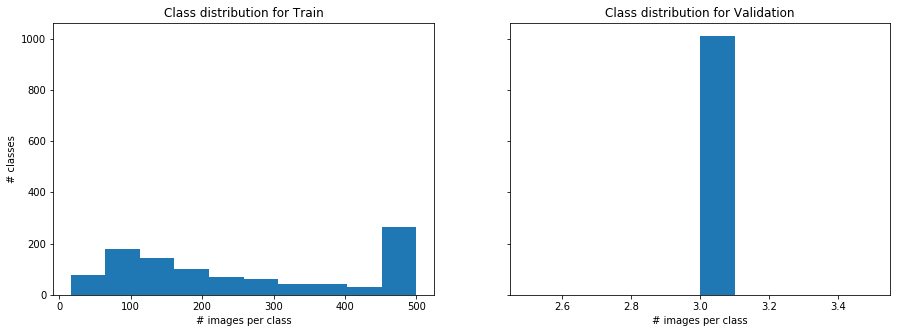

In [54]:
#plot class distribution
#clearly training data is quite unbalanced
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax0.hist(df_train.category_id.value_counts())
ax0.set_xlabel("# images per class")
ax0.set_ylabel("# classes")
ax0.set_title('Class distribution for Train')

ax1.hist(df_val.category_id.value_counts())
ax1.set_xlabel("# images per class")
ax1.set_title('Class distribution for Validation')
f;

In [59]:
#create databunch with batch size 64, normalize with imagenet stats
bs = 64
np.random.seed(42)
tfms = get_transforms(do_flip=True,
                      )


data = (ImageList.from_df(path=path, df=df_concat[cols])
       .split_from_df()
       .label_from_df()
       .add_test_folder(path/'test2019')
       .transform(tfms, size=224)
       .databunch(bs=bs)).normalize(imagenet_stats)

In [60]:
data

ImageDataBunch;

Train: LabelList (265213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
400,570,167,254,739
Path: /home/jupyter/kaggle/inaturalist/data;

Valid: LabelList (3030 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
644,597,883,300,881
Path: /home/jupyter/kaggle/inaturalist/data;

Test: LabelList (35350 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/inaturalist/data

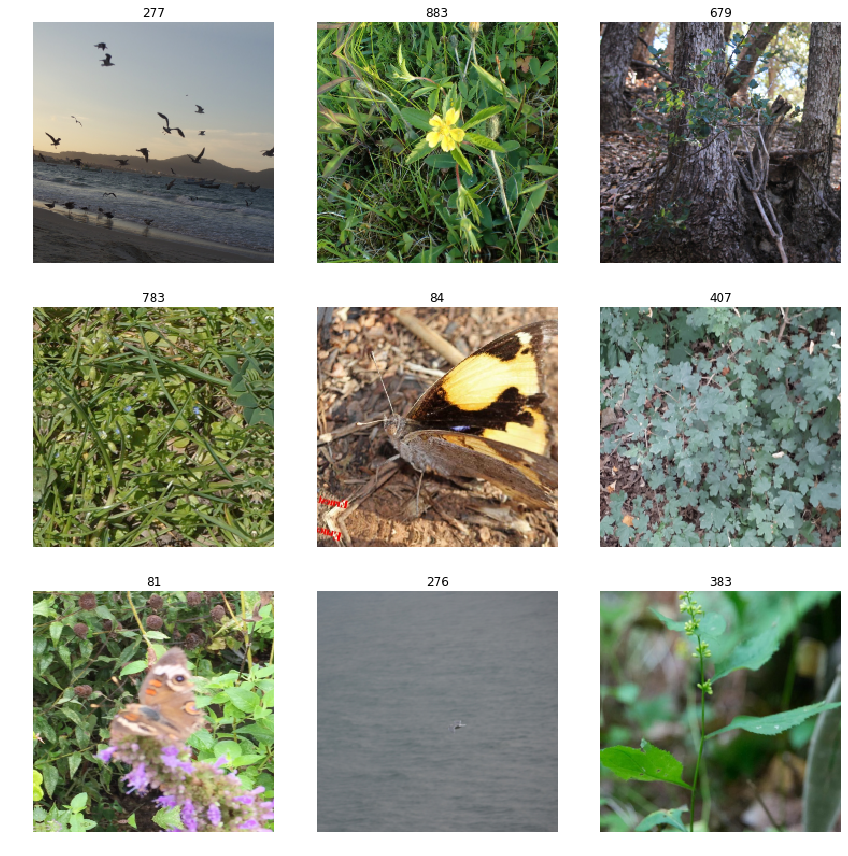

In [61]:
data.show_batch(rows=3)

In [62]:
# inceptionModel = inception(pretrained=True)
# for param in inceptionModel.parameters():
#     param.requires_grad = False
    
# num_ftrs = inceptionModel.AuxLogits.fc.in_features
# inceptionModel.AuxLogits.fc = nn.Linear(num_ftrs, len(data.classes))

# num_ftrs = inceptionModel.fc.in_features
# inceptionModel.fc = nn.Linear(num_ftrs, len(data.classes))

# inceptionModel.cuda()

In [63]:
# def my_loss(preds,target):
#     if type(preds) == tuple:
#         a, b = preds
#     else:
#         a = preds
#     return F.cross_entropy(a,target)

In [64]:
#learn = Learner(data, inceptionModel, loss_func=my_loss, metrics=[error_rate, accuracy])

In [65]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

In [66]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.753581,2.808456,0.629373,0.370627,46:10


In [138]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

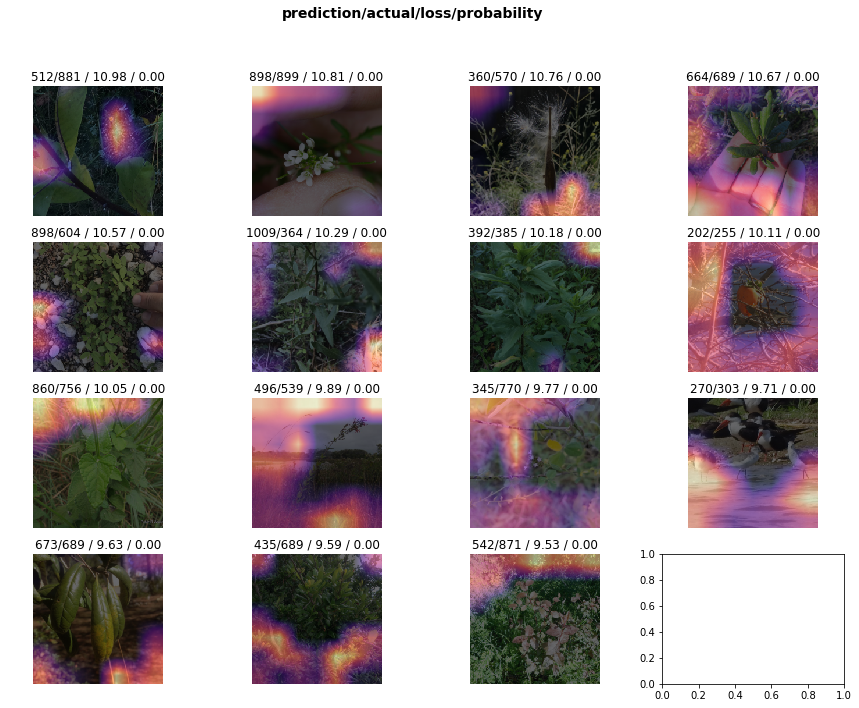

In [139]:
interp.plot_top_losses(15, figsize=(15,11))

In [165]:
df_val.head()

,category_id,file_name,height,id,license,rights_holder,width,image_id,train_valid,category_count
0,644,train_val2019/Plants/644/716a69838526f3ada3b2f...,618,265213,3,Adrian Stewart,800,265213,1,149
1,597,train_val2019/Plants/597/0942cc64d2e759c5ee059...,600,265214,3,張恒嘉,800,265214,1,221
2,883,train_val2019/Plants/883/acfdbfd9fa675f1c84558...,800,265215,3,Steve Kinne,600,265215,1,275
3,300,train_val2019/Birds/300/5f3194ff536c7dd31d80b7...,533,265216,3,Martin Grimm,800,265216,1,238
4,881,train_val2019/Plants/881/76acaf0b2841f91982d21...,506,265217,3,roy pilcher,800,265217,1,199


In [164]:
df_val = df_val.set_index('category_id')
df_val['category_count'] = df_train.groupby('category_id').sum()[['count']].loc[df_val.index]
df_val = df_val.reset_index()

In [181]:
df_val['losses'] = pd.Series(losses, index=idxs)

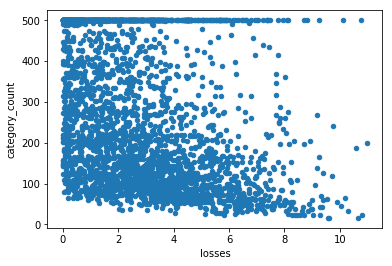

In [183]:
#plot num losses by category against training category count
#lower right quadrant of scatter implies that we tend to have more losses on low count categories
#i.e. categories with low training data perform worse
#need to find better solution for unbalanced training data, REVISIT
df_val.plot(x='losses', y='category_count', kind='scatter', )

In [140]:
learn.save('stage-1-50')

In [141]:
learn.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (265213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
400,570,167,254,739
Path: /home/jupyter/kaggle/inaturalist/data;

Valid: LabelList (3030 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
644,597,883,300,881
Path: /home/jupyter/kaggle/inaturalist/data;

Test: LabelList (35350 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/inaturalist/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


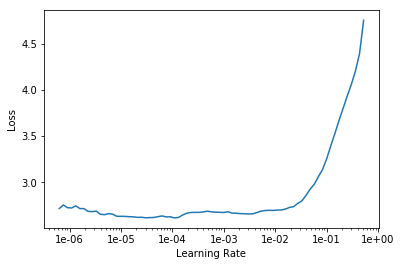

In [184]:
learn.lr_find(); learn.recorder.plot()

In [185]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.588910,2.723153,0.625743,0.374257,46:18
1,2.560766,2.690762,0.616502,0.383498,46:09


In [186]:
learn.save('stage-2-50')

In [187]:
learn.load('stage-2-50')

Learner(data=ImageDataBunch;

Train: LabelList (265213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
400,570,167,254,739
Path: /home/jupyter/kaggle/inaturalist/data;

Valid: LabelList (3030 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
644,597,883,300,881
Path: /home/jupyter/kaggle/inaturalist/data;

Test: LabelList (35350 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/inaturalist/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [188]:
learn.unfreeze()

In [189]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


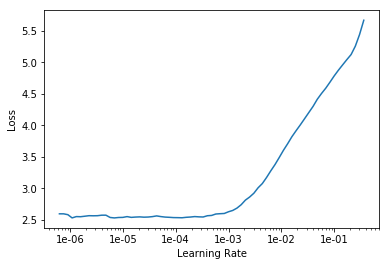

In [190]:
learn.recorder.plot()

In [191]:
learn.fit_one_cycle(1, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.385469,2.468819,0.581188,0.418812,54:09


In [192]:
#learn.save('stage-3-50')

In [10]:
learn.load('stage-3-50')

Learner(data=ImageDataBunch;

Train: LabelList (265213 items)
x: ImageList
Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560)
y: CategoryList
400,570,167,254,739
Path: /home/jupyter/kaggle/inaturalist/data;

Valid: LabelList (3030 items)
x: ImageList
Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560)
y: CategoryList
644,597,883,300,881
Path: /home/jupyter/kaggle/inaturalist/data;

Test: LabelList (35350 items)
x: ImageList
Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560),Image (3, 560, 560)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/inaturalist/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [11]:
learn.freeze()

In [8]:
#reload data at a higher size
bs = 8
np.random.seed(42)
tfms = get_transforms(do_flip=True,
                      )


data = (ImageList.from_df(path=path, df=df_concat[cols])
       .split_from_df()
       .label_from_df()
       .add_test_folder(path/'test2019')
       .transform(tfms, size=560)
       .databunch(bs=bs))

In [16]:
learn.data = data
torch.cuda.empty_cache()

In [12]:
#this yields worse results
learn.fit_one_cycle(1, slice(1e-6, 1e-4), wd=.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.645700,3.805125,0.693729,0.306271,4:18:59


In [11]:
#learn.save('stage-4-50')

Learner(data=ImageDataBunch;

Train: LabelList (265213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
400,570,167,254,739
Path: /home/jupyter/kaggle/inaturalist/data;

Valid: LabelList (3030 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
644,597,883,300,881
Path: /home/jupyter/kaggle/inaturalist/data;

Test: LabelList (35350 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/kaggle/inaturalist/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

In [195]:
#get test set predictions and format for submission
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [196]:
pred_classes = torch.Tensor(data.classes)[preds.argmax(dim=1)]

In [197]:
df_test = pd.DataFrame(x_test['images'])
df_test_ds = pd.DataFrame(data.test_ds.items).rename(columns={0:'path'})
df_test_ds['path'] = df_test_ds['path'].astype(str)
df_test_ds['path'] = df_test_ds['path'].str.split("/").str[-2:].str.join("/")

df_result = pd.DataFrame()
df_result['id'] = df_test.set_index('file_name').loc[df_test_ds['path']]['id']
df_result = df_result.reset_index(drop=True)

In [198]:
df_result['predicted'] = pred_classes
df_result['predicted'] = df_result['predicted'].astype(int)

In [199]:
df_result = df_result.sort_values('id')

In [200]:
df_result.to_csv(path/'submission.csv', index=False)

In [201]:
df_result.head()

,id,predicted
34961,268243,9
19772,268244,212
32191,268245,599
33524,268246,161
16828,268247,150
